In [1]:
### run the script from the figures_code directory
import os
import sys
os.chdir('../')
import pandas as pd
import numpy as np
from glob import glob
import seaborn as sns
import re
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from Bio.Seq import Seq
from functions import parsing
from functions import params
from functions import data_processing as dp
from functions import basic_figures as bf
from functions import general_functions as gf
from functions import lib_table_operations as lto
from Bio import pairwise2
from importlib import reload
from scipy import stats
from scipy.stats import zscore

/home/labs/barkailab/tamarj/.conda/envs/cobind/lib/python3.9/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


In [2]:
plt.rcParams.update({'font.size': 16})
tf_sumprom = params.TF_SUMPROM
tf_zscore_sp = tf_sumprom.apply(zscore, nan_policy='omit')
GP = params.GP
CER_GENOME = params.CER_GENOME
LAB_WT_NORM = params.LAB_WT_NORM
libs = params.LIBS_INFO.set_index('Number')
RES_PATH = params.RES_PATH

## (A) Msn2 & Sok2 dependency on non-self motifs

<AxesSubplot: xlabel='Main_tf', ylabel='Second_contribution'>

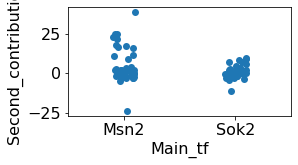

In [3]:
tp = '180'
wanted_exps = [13,14,16,25]
to_p = 100
thresh = -1
pattern = r'[0-9]'
wanted_tfs = ['Msn2','Sok2']
dep_df = pd.DataFrame()
for curr_tf in wanted_tfs:
    tf_files = [file for file in dp.find_tf_files(curr_tf) if int(file.split('.')[0].split('_')[2]) in wanted_exps]
    lib_nums = list(set([file.split('.')[0].split('_')[1] for file in tf_files]))
    for curr_lib in lib_nums:
        lib_info = dp.get_lib_info(curr_lib)
        lib_files = [i for i in tf_files if i.split('.')[0].split('_')[1]==str(curr_lib)]
        curr_exps = [i.split('.')[0].split('_')[2] for i in lib_files]
        res = lto.combine_2_exps(curr_tf, curr_lib, tp, curr_exps, norm_to=0)
        _,_,on_dict,off_dict,_,_ = lto.get_all_tf_motifs_wt_or_mut(curr_tf,lib_info,res.index)
        tf_pos,non_tf_pos = lto.get_tf_positions(lib_info,curr_tf)
        tf_on_ids = []
        for pos in tf_pos:
            tf_on_ids = tf_on_ids + on_dict[pos]
        pos_contribution = []
        for pos in non_tf_pos:
            pos_on_tf_off = np.setdiff1d(on_dict[pos],tf_on_ids)
            pos_off_tf_off = np.setdiff1d(off_dict[pos],tf_on_ids)
            pos_contribution.append(lto.convert_fc_to_occ(res.iloc[pos_on_tf_off].mean().mean() - res.iloc[pos_off_tf_off].mean().mean()))
        if pos_contribution:
            max_val = np.max(pos_contribution)
            if np.sum(np.array(pos_contribution)>thresh)>0:
                main_tf_contribution = []
                mut_seq = lto.get_mut_var(curr_lib)
                for pos in tf_pos:
                    _,only_on_id = lto.get_values_by_wt_pos([pos],res,curr_lib)
                    main_tf_contribution.append(lto.convert_fc_to_occ((res.iloc[only_on_id].mean(axis=1).values-res.loc[mut_seq].mean())[0]))
                if len(tf_pos)>0:
                    main_tf_max_pos = tf_pos[np.argmax(main_tf_contribution)]
                tf2_max_pos = non_tf_pos[np.where(np.array(pos_contribution)>thresh)]
                impact_vals = np.array(pos_contribution)[np.array(pos_contribution)>thresh]
                for i,impact_pos in enumerate(tf2_max_pos):
                    if len(tf_pos)>0:
                        mot_dist = lto.get_min_dist_tf(curr_lib,curr_tf,main_tf_max_pos,impact_pos)
                    tf2 = re.sub(pattern, '', lib_info['mut_by_tf'][impact_pos].split('/')[0])
                    dep_df = pd.concat([dep_df,pd.DataFrame([curr_tf,tf2,curr_lib,main_tf_max_pos,impact_pos,mot_dist,impact_vals[i]*to_p]).T])
dep_df.reset_index(inplace=True,drop=True)    
dep_df.columns = ['Main_tf','Second_tf','Library','Main_pos','Second_pos','Distance','Second_contribution']
fig,ax = plt.subplots(1,1,figsize=(4,2))
sns.stripplot(data=dep_df,x='Main_tf',y='Second_contribution',s=7)


## (B) Distance of non-Msn2 dependent motifs from the Msn2 preferred binding sequence

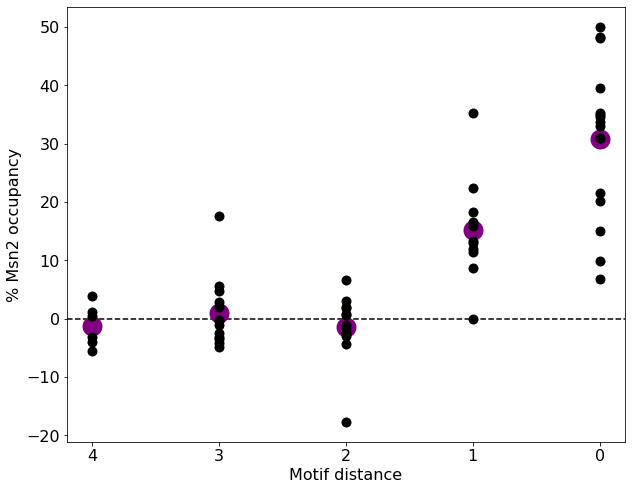

In [4]:
main_motif = 'AGGGG'
main_tf = 'Msn2'
libs_to_rem = [46,88]

relevant_files = [i for i in dp.find_tf_files(main_tf) if int(i.split('.')[0].split('_')[2]) in wanted_exps and int(i.split('.')[0].split('_')[1]) not in libs_to_rem]
relevant_files
lib_nums = list(set([i.split('.')[0].split('_')[1] for i in relevant_files]))
fcols = ['TF','Lib','Pos','M_Score']
info_df = pd.DataFrame()
sim_mots = []
for curr_lib in lib_nums:
    lib_info = dp.get_lib_info(curr_lib)
    mot_info = dp.get_motif_info_by_pos(curr_lib)
    lib_wt_seq = lib_info['wt_seq']
    # tf_positions = mot_info.loc[mot_info['TF'].str.contains(tf_query)]['Pos'].values
    main_pos = mot_info.loc[mot_info['TF'].str.contains(main_tf.upper())]['Pos'].values
    for m_pos in main_pos:
        info_df = pd.concat([info_df,pd.DataFrame(['Msn2',curr_lib,m_pos,len(main_motif)]).T])
    non_tf_pos = [x for x in range(len(lib_info['mut_loc'])) if x not in main_pos]
    for pos in non_tf_pos:
        tf_opts = mot_info.loc[mot_info['Pos']==pos]
        pos_sim = []
        for i,x in enumerate(tf_opts.index):
            st_pos = tf_opts.iloc[i,:]['Start']
            end_pos = tf_opts.iloc[i,:]['End']        
            tf_mot = Seq(lib_wt_seq[st_pos:end_pos])
            tf_mot_rc = Seq.reverse_complement(Seq(lib_wt_seq[st_pos:end_pos]))
            pos_sim.append(int(np.max([pairwise2.align.globalxx(Seq(main_motif), tf_mot)[0].score
                                   ,pairwise2.align.globalxx(Seq(main_motif), tf_mot_rc)[0].score])))
        info_df = pd.concat([info_df,pd.DataFrame([tf_opts.iloc[np.argmax(pos_sim)]['TF'],curr_lib,pos,np.max(pos_sim)]).T])

info_df.columns = fcols
info_df.drop_duplicates(inplace=True)
info_df.reset_index(drop=True,inplace=True)
tf = 'Msn2'
tp = '180'
tf_exps = [13,26]
to_perc = 100
c_mean = []
c_sem = []
for i,lib_num in enumerate(info_df['Lib'].values):
    tf_lib_res = lto.convert_fc_to_occ(lto.combine_2_exps(tf, lib_num, tp, tf_exps, norm_to=None))
    single_pos_effect, single_pos_sem = lto.only_pos_intact_change_calc(tf, lib_num, exp_num=None, norm_to=None, occ=True, norm_df=tf_lib_res)
    c_mean.append(single_pos_effect.iloc[:,info_df.iloc[i,:]['Pos']].values[0]*100)
    c_sem.append(single_pos_sem.iloc[:,info_df.iloc[i,:]['Pos']].values[0]*100)    
info_df['Msn2_mean'] = c_mean
info_df['Msn2_sem'] = c_sem            
fig,ax = plt.subplots(1,1,figsize=(10,8))
for_scat = info_df[['M_Score','Msn2_mean']].drop_duplicates()
sns.scatterplot(data=for_scat,x='M_Score',y='Msn2_mean',s=100,ax=ax, zorder=20,color='k',linewidth=0)
ax.scatter([1,2,3,4,5],for_scat.groupby('M_Score').mean()['Msn2_mean'].values,s=400,c='purple',linewidths=0,zorder=19)
ax.set_xticks([1,2,3,4,5])
ax.set_xticklabels(['4','3','2','1','0'])
ax.set_xlabel('Motif distance')
ax.set_ylabel('% Msn2 occupancy')
ax.axhline(0,c='k',linestyle='--')
plt.show()


## (C) Msn2,DBD,DBDOE Motif binding histograms

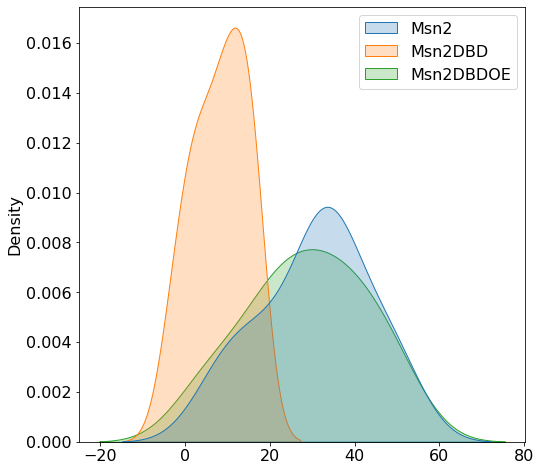

In [5]:
main_tfs = ['Msn2','Msn2DBD','Msn2DBDOE']
tp = '180'
to_prec = 100
wanted_cols = ['tf_mot','tf_measured','values','lib','pos','exp']
wanted_exps = [13,14,26]
libs_to_rem = [46,88]
fin_df = pd.DataFrame()
for main_tf in main_tfs:
    relevant_files = [i for i in dp.find_tf_files(main_tf) if int(i.split('.')[0].split('_')[2]) in wanted_exps and int(i.split('.')[0].split('_')[1]) not in libs_to_rem]
    for file in relevant_files:
        _,lib_num,exp = file.split('.')[0].split('_')
        lib_info = dp.get_lib_info(lib_num)
        curr_single_pos_intact,_ = lto.only_pos_intact_change_calc(main_tf,lib_num,exp_num=exp,norm_to=None,occ=True,norm_df=None)
        curr_single_pos_intact = curr_single_pos_intact.loc[tp]
        tf_list = []
        main_tf_list = []
        vals_list = []
        lib_list = []
        exp_list = []
        pos_list = []
        pos = 0
        for curr_i in range(len(curr_single_pos_intact)): 
            curr_tfs = curr_single_pos_intact.index[curr_i]
            curr_val = curr_single_pos_intact.values[curr_i]              
            for c_tf in curr_tfs.split('/'):
                tf_list.append(c_tf)
                vals_list.append(curr_val*to_prec)
                lib_list.append(lib_info['gene'])
                exp_list.append(exp)
                main_tf_list.append(main_tf)
                pos_list.append(pos)
            pos+=1
            curr_df = pd.DataFrame([tf_list,main_tf_list,vals_list,lib_list,pos_list,exp_list]).T
        fin_df = pd.concat([fin_df,curr_df])
fin_df.columns = wanted_cols
fig,ax = plt.subplots(1,1,figsize=(8,8))
tf = 'Msn2'
df_m2mot = fin_df.loc[fin_df['tf_mot']==tf]
main_tfs = ['Msn2','Msn2DBD','Msn2DBDOE']
mot_b = pd.DataFrame()
for curr_main in main_tfs:
    curr_sub = df_m2mot.loc[df_m2mot['tf_measured']==curr_main]
    # mot_b = pd.concat([mot_b,curr_sub.groupby(['lib','pos']).mean()['values']],axis=1)
    mot_b = pd.concat([mot_b,curr_sub[['lib','pos','values']].groupby(['lib','pos']).mean()],axis=1)
    
mot_b.columns = main_tfs
sns.kdeplot(data=mot_b,fill=True)
plt.show()

## (E) Swarmplots of Position binding of Msn2 and DBDOE, divided into groups - Msn2 motifs, non Msn2 motifs and non Msn2 motifs that are bound

/home/labs/barkailab/tamarj/.conda/envs/cobind/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 11.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


(-20.0, 80.0)

/home/labs/barkailab/tamarj/.conda/envs/cobind/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 8.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/labs/barkailab/tamarj/.conda/envs/cobind/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 8.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/labs/barkailab/tamarj/.conda/envs/cobind/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 8.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


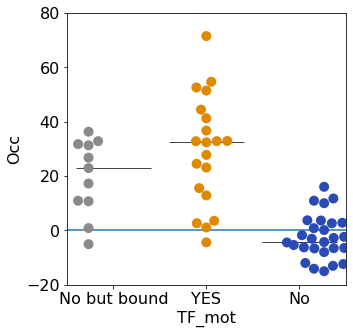

In [7]:
thresh = 10
exp = 14
to_perc = 100
tp = '180'

tfs = ['Msn2DBDOE']
for tf in tfs:
    nonm2_bound = dep_df.loc[dep_df['Main_tf']=='Msn2'][dep_df.loc[dep_df['Main_tf']=='Msn2','Second_contribution']>thresh]
    nonm2_bound.reset_index(inplace=True)
    nonm2_bound = nonm2_bound[['Library','Second_pos']]
    rel_libs = [file.split('.')[0].split('_')[1] for file in dp.find_tf_files(tf) if
                file.split('.')[0].split('_')[2]==str(exp)]
    pos_df = pd.DataFrame()
    for curr_lib in rel_libs:
        curr_res,_ = lto.only_pos_intact_change_calc(tf,curr_lib,exp,occ=True)
        curr_res = curr_res*to_perc
        curr_res.columns = range(curr_res.columns.size)
        ntps = len(curr_res.index)
        npos = len(curr_res.columns)
        curr_res = curr_res.unstack().reset_index()
        tfp,nontfp = lto.get_tf_positions(dp.get_lib_info(curr_lib),tf)
        curr_res.columns = ['Pos','TP','Occ']
        curr_res['TF_mot'] = len(curr_res['Pos'])*['No']
        for pos in tfp:
            curr_res.loc[curr_res['Pos']==pos,'TF_mot'] = 'YES'
        curr_res['library'] = [curr_lib]*len(curr_res['Pos'])
        pos_df = pd.concat([pos_df,curr_res])
    main_tp = '180'
    pos_df.reset_index(drop=True,inplace=True)
    for r in nonm2_bound.index:
        curr_cond = (pos_df['Pos']==nonm2_bound.iloc[r]['Second_pos']) & (pos_df['library']==nonm2_bound.iloc[r]['Library'])
        pos_df.loc[curr_cond,'TF_mot'] = 'No but bound'
sub_df_for_plot = pos_df.loc[pos_df['TP']==tp]
fig,ax = plt.subplots(1,1,figsize=(5,5))
sns.swarmplot(data=sub_df_for_plot,y='Occ',x='TF_mot', dodge=True,hue_order=['No','No but bound','YES']
                  ,palette=['#8a8a8a','#de8900','#2a4ab5'],ax=ax,s=10)
sns.boxplot(data=sub_df_for_plot,y='Occ',x='TF_mot',hue_order=['No','No but bound','YES'],palette=['#8a8a8a','#de8900','#2a4ab5'],ax=ax, 
               boxprops=dict(linewidth=1, facecolor='w', edgecolor='w', alpha=1),
                whiskerprops=dict(linewidth=0.75, color='w', alpha=1), showfliers=False,showcaps=False)
plt.axhline(0)
plt.ylim(-20,80)

## (F) - Msn2 wild-type vs Msn2 DBD OE: occupancy over library sequences of Hxk1, Ego4, Gsy2

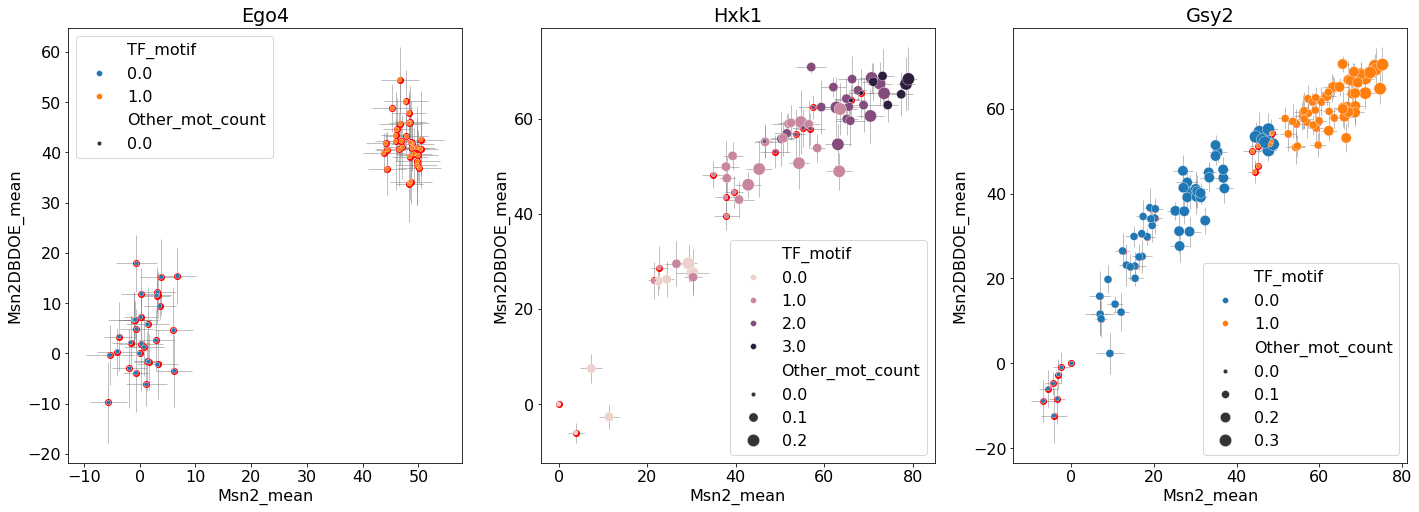

In [8]:
tfs = ['Msn2', 'Msn2DBDOE']
ref_tf = 'Msn2'
exps = [['13', '26'], ['14','26']]
tp='180'
effect_tresh = 0.1 
libs = ['78', '87', '32']
tf_split = re.findall('\d*\D+',ref_tf)[0]
ref_tf_id = 0

fig, axes = plt.subplots(1,3, figsize=(24,8))
for lib_i, lib_num in enumerate(libs):
    lib_info = dp.get_lib_info(lib_num) # get library information
    comb_df = lto.convert_fc_to_occ(lto.combine_2_exps(ref_tf, lib_num, tp, exps[ref_tf_id], norm_to=None))
    single_pos_effect,_ = lto.only_pos_intact_change_calc(ref_tf, lib_num, exp_num=None, norm_to=None, norm_df=comb_df)
    tf_pos = [i for i,curr_tf_mut in enumerate(lib_info['mut_by_tf']) if tf_split in curr_tf_mut]
    effective_pos = effective_pos = np.where(single_pos_effect.loc[tp] > effect_tresh)[0]
    other_tf_pos=[]
    if len(effective_pos)!=len(tf_pos):
        for pos in tf_pos:
            if pos in effective_pos:
                effective_pos = np.delete(effective_pos, np.where(effective_pos==pos)[0])
        other_tf_pos = effective_pos

    wt_var_seq = ''.join(lib_info['wt_at_var_loc']) # wt seq
    mut_var_seq = lto.get_mut_var(lib_num) # mutated seq
    
    
    norm_df = pd.DataFrame()
    for tf_i,tf in enumerate(tfs):
        curr_exp_df_mean = dp.mean_over_bio_reps(lto.convert_fc_to_occ(lto.combine_2_exps(tf, lib_num, tp, exps[tf_i], norm_to=None))*100)
        curr_exp_df_mean = curr_exp_df_mean.add_suffix('_mean')
        curr_exp_df_sem = dp.sem_over_bio_reps(lto.convert_fc_to_occ(lto.combine_2_exps(tf, lib_num, tp, exps[tf_i], norm_to=None))*100)
        curr_exp_df_sem = curr_exp_df_sem.add_suffix('_sem')
        curr_exp_df = pd.concat([curr_exp_df_mean, curr_exp_df_sem], axis=1)
        curr_exp_df.columns = [tf+'_'+'mean', tf+'_'+'sem']
        norm_df = pd.concat([norm_df, curr_exp_df],axis=1)

    seqs = norm_df.index # library sequences
    all_seqs_split = np.array([list(seq) for seq in seqs]) # library sequences spli
    tf_intact_motif_seqs = np.zeros((len(seqs),len(tf_pos)))
    for i, pos in enumerate(tf_pos):
        tf_intact_motif_seqs[all_seqs_split[:,pos]==wt_var_seq[pos], i] = 1
    norm_df['TF_motif'] = np.sum(tf_intact_motif_seqs, axis=1)

    other_tf_mot_count = np.zeros((len(seqs),len(other_tf_pos)))
    for i, pos in enumerate(other_tf_pos):
        other_tf_mot_count[all_seqs_split[:,pos]==wt_var_seq[pos], i] = 1
    norm_df['Other_mot_count'] = np.sum(other_tf_mot_count, axis=1)
    ax=sns.scatterplot(data=norm_df, x=tfs[0]+'_'+'mean', y=tfs[1]+'_'+'mean', hue='TF_motif',
                       size=norm_df['Other_mot_count']/10, sizes=(20,150),zorder=20, ax=axes.ravel()[lib_i])
    ax.errorbar(norm_df[tfs[0]+'_'+'mean'], norm_df[tfs[1]+'_'+'mean'], xerr=norm_df[tfs[0]+'_'+'sem'],
                 yerr=norm_df[tfs[1]+'_'+'sem'],ecolor='grey',elinewidth=0.5, color='r', fmt='o')
    
    ax.set_title(lib_info['gene'])

## (G) Correlation histogram - Msn2 wilde-type vs Msn2 DBDOE

Msn2 0.3999851078402105 0.9891403120761477
Msn2DBDOE nan nan


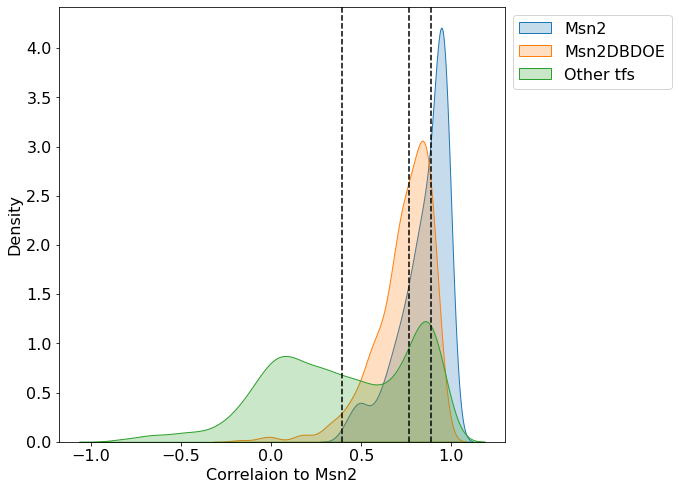

In [9]:
ignore_exps=['12', '18','19', '21', '23']
libs_to_rm = ['46', '88']
tfs_to_rm = ['Msn2DBD', 'Med15', 'Msn2OE']
cols=['TF','Lib_num', 'Exp_num', 'File']
lib_nums = np.unique([file.split('.')[0].split('_')[1] for file in dp.find_tf_files('Msn2')])
tf_files = pd.DataFrame()
for lib_num in lib_nums:
    lib_files = dp.find_lib_files(lib_num)
    for file in lib_files:
        tf,lib_num,exp_num = file.split('.')[0].split('_')
        if (exp_num not in ignore_exps) & (lib_num not in libs_to_rm) & (tf not in tfs_to_rm):
            tf_files = pd.concat([tf_files, pd.DataFrame(np.reshape([tf, lib_num, exp_num, file],
                                                                                (1,len(cols))), columns=cols)])
tp = '180'
ref_tf = 'Msn2'
lib_nums = tf_files['Lib_num'].unique()
tf_corr = {key: [] for key in tf_files['TF'].unique()}
for lib_num in lib_nums:
    lib_subset = tf_files.query("Lib_num==@lib_num")
    lib_tfs = lib_subset['TF'].unique()
    ref_tf_i = np.where(lib_tfs==ref_tf)[0]
    lib_tfs = np.delete(lib_tfs, ref_tf_i)
    
    ref_exps = tf_files.query("TF==@ref_tf & Lib_num==@lib_num")['Exp_num'].values
    ref_exps = tf_files.query("TF==@ref_tf & Lib_num==@lib_num")['Exp_num'].values
    ref_lib_res = lto.combine_2_exps(ref_tf, lib_num, tp, ref_exps, norm_to=None)
    ref_lib_res.columns = [ref_tf] * len(ref_lib_res.columns)

    ref_corr = ref_lib_res.corr()
    ref_corr_vals_dup = np.concatenate(ref_corr.values)
    ref_corr_vals_mat=np.reshape(ref_corr_vals_dup, ref_corr.shape)
    triu_i = np.triu_indices(len(ref_corr))
    ref_corr_vals = ref_corr_vals_mat[triu_i]
    ref_corr_vals = ref_corr_vals[(ref_corr_vals!=1)]
    tf_corr[ref_tf].append(ref_corr_vals)
    
    for tf_i, tf in enumerate(lib_tfs):
        lib_tf_subset = lib_subset.query("TF==@tf")
        if len(lib_tf_subset)>1:
            tf_exps = tf_files.query("TF==@tf & Lib_num==@lib_num")['Exp_num'].values
            tf_lib_res = lto.combine_2_exps(tf, lib_num, tp, tf_exps, norm_to=None)
        else: 
            exp_num = lib_tf_subset['Exp_num'].values[0]
            file_name = tf + '_' + str(lib_num) + '_' + str(exp_num) + '.csv'  # looking for the relevant results file based on our system ('tf_libnum_exp.csv')
            norm_res = dp.norm_reads(pd.read_csv(os.path.join(RES_PATH, file_name), index_col=0))  # reading current result table into pd dataframe            
            sample_filt_norm, _ = dp.rm_samples(tf, lib_num, exp_num, norm_res)
            sample_info = dp.get_samp_info(sample_filt_norm)
            log2_norm = dp.res_log2(sample_filt_norm)
            norm_tp_0 = dp.norm_to_tp_0(log2_norm, sample_info)
            tf_lib_res = lto.norm_non_cut(lib_num, norm_tp_0, None)
        tf_lib_res.columns = [tf] * len(tf_lib_res.columns)
        corr_df = pd.concat([ref_lib_res,tf_lib_res],axis=1).corr()
        relevant_corr = corr_df.iloc[corr_df.index==tf, corr_df.columns==ref_tf]
        corr_vals = np.concatenate(relevant_corr.values)
        tf_corr[tf].append(corr_vals)
        

fig,ax = plt.subplots(1,1,figsize=(8,8))       
all_tfs = tf_files['TF'].unique()
relevant_tfs = ['Msn2', 'Msn2DBDOE']
median_vals = []
for tf in relevant_tfs:
    all_tfs = np.delete(all_tfs, np.where(all_tfs==tf)[0])
    corr_tf_concat = np.concatenate(tf_corr[tf])
    corr_tf_median = np.nanmedian(corr_tf_concat)                                          
    sns.kdeplot(x=corr_tf_concat, fill=True, ax=ax)
    median_vals.append(corr_tf_median)
    print(tf, min(corr_tf_concat), max(corr_tf_concat))

all_tfs_corrs = []
for tf in all_tfs:
    all_tfs_corrs.append(np.concatenate(tf_corr[tf]))

all_corr_concat = np.concatenate(all_tfs_corrs)
all_corr_concat_median = np.nanmedian(all_corr_concat)
median_vals.append(all_corr_concat_median)

sns.kdeplot(x=all_corr_concat, fill=True, common_norm=False, ax=ax)    
ax.set_xlabel('Correlaion to Msn2')
ax.legend(relevant_tfs+['Other tfs'],loc='upper left', bbox_to_anchor=(1, 1))

for val in median_vals:
    ax.axvline(val, color='k', linestyle='--')